# Supply Chain Logistics Problem

The purpose of this project is to **analyze and optimize the supply chain logistics network** of a global microchip producer. By leveraging real-world data on orders, warehouses, freight rates, and customer relationships.

### Dataset Description

The data is sourced from a Microsoft Excel file, Supply chain logistics problem.xlsx, containing the following sheets:

- OrderList: Detailed information about customer orders, including the product, warehouse, carrier, weight, and destination port.
- FreightRates: Details about carriers, weight bands, shipping rates, modes of transport, and estimated transport days.
    WhCosts: Storage costs per unit for each warehouse.
    WhCapacities: Daily capacity constraints for each warehouse.
    PlantPorts: Mapping of warehouses (plants) to allowed shipping ports.
    ProductsPerPlant: List of products supported by each warehouse.
    VmiCustomers: Special warehouse-customer relationships.

## 1. Load Data

In [1]:
from scipy.optimize import linprog
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

In [2]:
# Define the path to the Excel file
excel_file_path = 'Supply chain logistics problem.xlsx'

# Load all required sheets into DataFrames using the correct tab names
order_list = pd.read_excel(excel_file_path, sheet_name='OrderList')
freight_rates = pd.read_excel(excel_file_path, sheet_name='FreightRates')
warehouse_costs = pd.read_excel(excel_file_path, sheet_name='WhCosts')
warehouse_capacities = pd.read_excel(excel_file_path, sheet_name='WhCapacities')
plant_ports = pd.read_excel(excel_file_path, sheet_name='PlantPorts')
products_per_plant = pd.read_excel(excel_file_path, sheet_name='ProductsPerPlant')
vmi_customers = pd.read_excel(excel_file_path, sheet_name='VmiCustomers')

# Confirm successful loading of all sheets
print("All sheets loaded successfully!")

All sheets loaded successfully!


In [20]:
# Display the first few rows of each dataset for verification
datasets = {
    "Order List": order_list,
    "FreightRates": freight_rates,
    "Warehouse Costs": warehouse_costs,
    "Warehouse Capacities": warehouse_capacities,
    "Plant Ports": plant_ports,
    "Products per Plant": products_per_plant,
    "Customers": vmi_customers
}

for name, df in datasets.items():
    print(f"\n{name} Preview:")
    print(df.head())
    print(df.info())
    print(df.describe())


Order List Preview:
       Order ID Order Date Origin Port Carrier  TPT Service Level  \
0  1.447296e+09 2013-05-26      PORT09   V44_3    1           CRF   
1  1.447158e+09 2013-05-26      PORT09   V44_3    1           CRF   
2  1.447139e+09 2013-05-26      PORT09   V44_3    1           CRF   
3  1.447364e+09 2013-05-26      PORT09   V44_3    1           CRF   
4  1.447364e+09 2013-05-26      PORT09   V44_3    1           CRF   

   Ship ahead day count  Ship Late Day count   Customer  Product ID  \
0                     3                    0  V55555_53     1700106   
1                     3                    0  V55555_53     1700106   
2                     3                    0  V55555_53     1700106   
3                     3                    0  V55555_53     1700106   
4                     3                    0  V55555_53     1700106   

  Plant Code Destination Port  Unit quantity  Weight  
0    PLANT16           PORT09            808   14.30  
1    PLANT16           PORT

## 2. Exploratory Data Analysis and Visualization

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\2783502564.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Plant Code", data=order_list, order=order_list["Plant Code"].value_counts().index, palette="viridis")


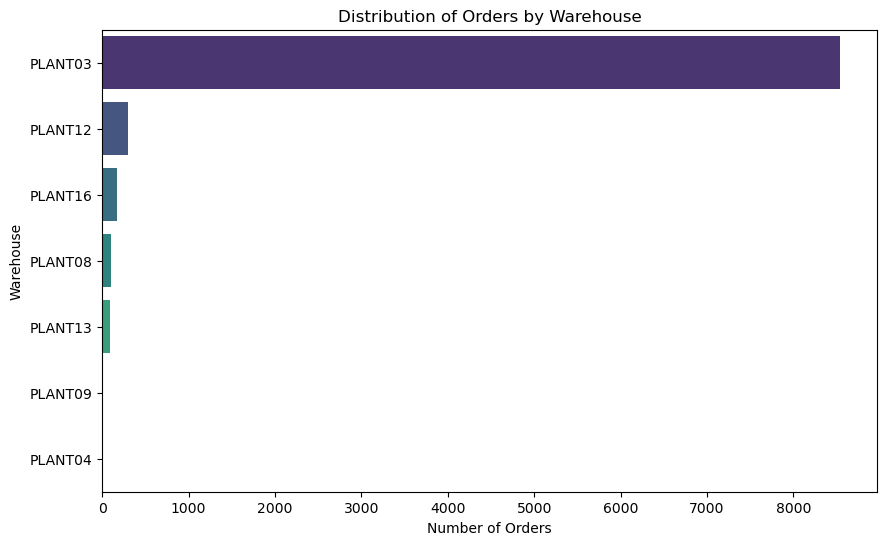

In [4]:
# Distribution of Orders by Warehouse
plt.figure(figsize=(10, 6))
sns.countplot(y="Plant Code", data=order_list, order=order_list["Plant Code"].value_counts().index, palette="viridis")
plt.title("Distribution of Orders by Warehouse")
plt.xlabel("Number of Orders")
plt.ylabel("Warehouse")
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\4085931347.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=service_level_counts.index, y=service_level_counts.values, palette="coolwarm")


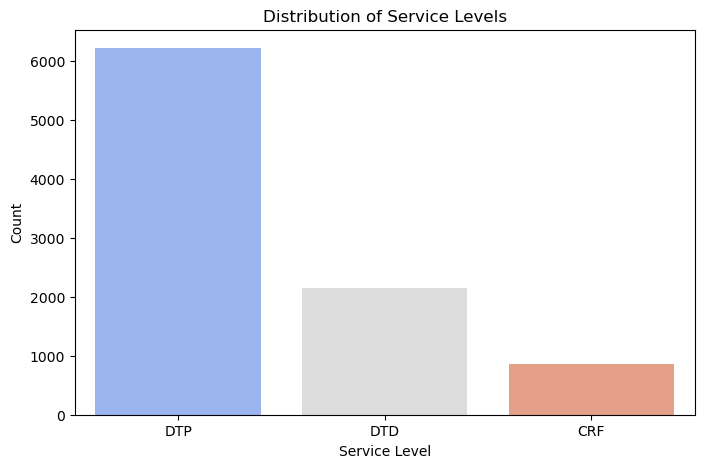

In [5]:
# Distribution of Service Levels
plt.figure(figsize=(8, 5))
service_level_counts = order_list["Service Level"].value_counts()
sns.barplot(x=service_level_counts.index, y=service_level_counts.values, palette="coolwarm")
plt.title("Distribution of Service Levels")
plt.xlabel("Service Level")
plt.ylabel("Count")
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\2204001872.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=freight_rates, x="mode_dsc", palette="pastel")


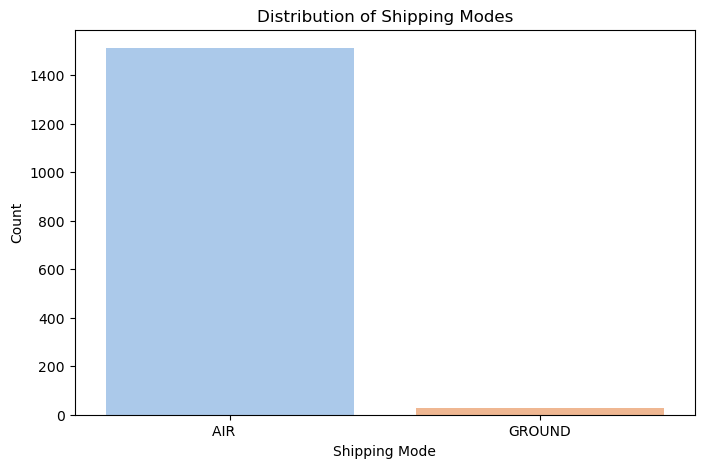

In [6]:
# Distribution of Shipping Modes
plt.figure(figsize=(8, 5))
sns.countplot(data=freight_rates, x="mode_dsc", palette="pastel")
plt.title("Distribution of Shipping Modes")
plt.xlabel("Shipping Mode")
plt.ylabel("Count")
plt.show()

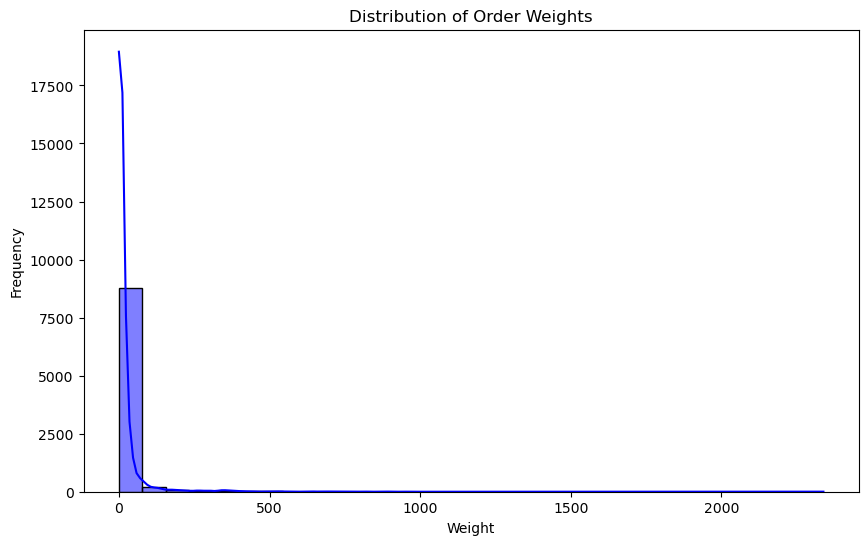

In [7]:
# Distribution of Weight
plt.figure(figsize=(10, 6))
sns.histplot(order_list["Weight"], bins=30, kde=True, color="blue")
plt.title("Distribution of Order Weights")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\4189489747.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=freight_rates, x="Carrier", y="rate", palette="Set3")


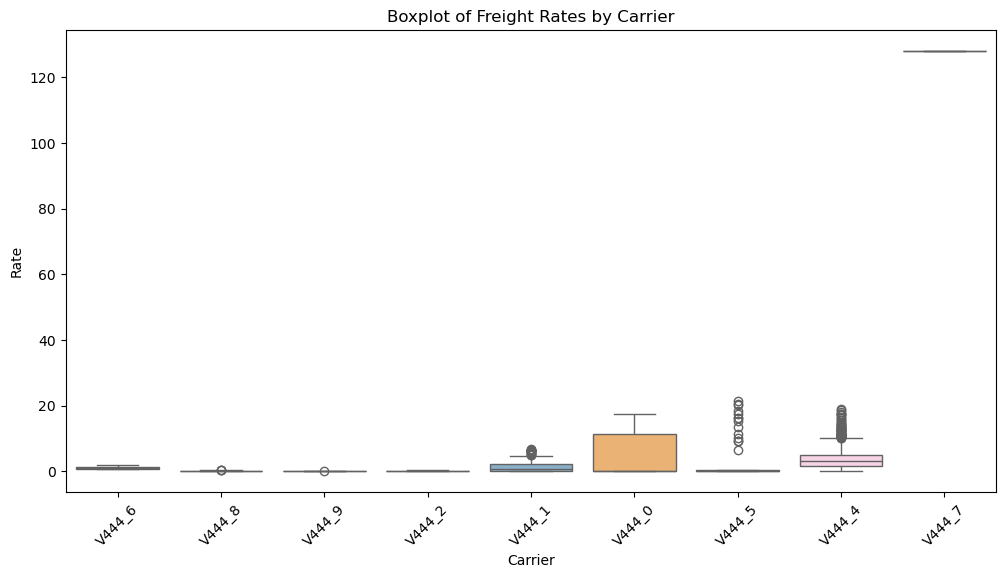

In [8]:
# Boxplot of Freight Rates by Carrier
plt.figure(figsize=(12, 6))
sns.boxplot(data=freight_rates, x="Carrier", y="rate", palette="Set3")
plt.title("Boxplot of Freight Rates by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.show()

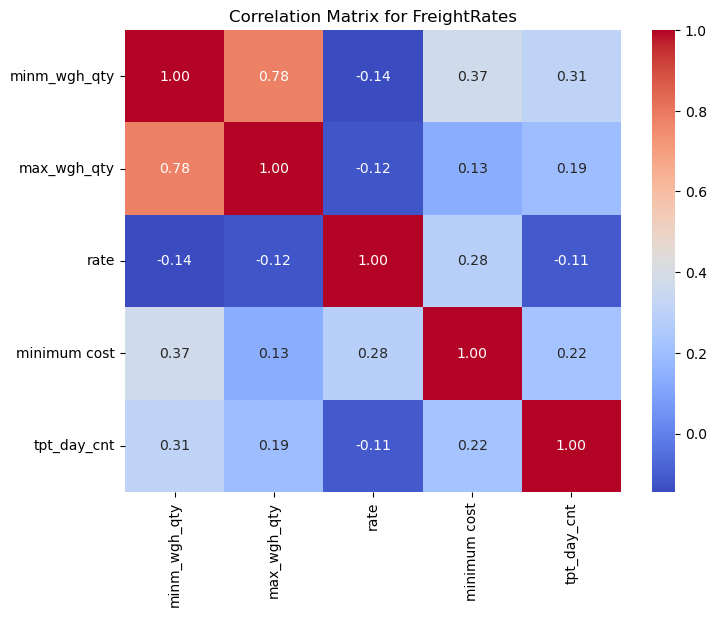

In [9]:
# Correlation Matrix for FreightRates
plt.figure(figsize=(8, 6))
corr = freight_rates[["minm_wgh_qty", "max_wgh_qty", "rate", "minimum cost", "tpt_day_cnt"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for FreightRates")
plt.show()

### Key Observation

- Larger shipment categories (higher minm_wgh_qty and max_wgh_qty) generally benefit from lower rates but have higher minimum costs and slightly longer delivery times.
- Rates tend to decrease as shipment weight increases, suggesting volume-based discounts.
- There is a complex relationship between transport days, rates, and minimum costs, likely reflecting different service levels (e.g., express vs. standard shipping).

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\3059677621.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=warehouse_capacities, x="Plant ID", y="Daily Capacity ", palette="muted")


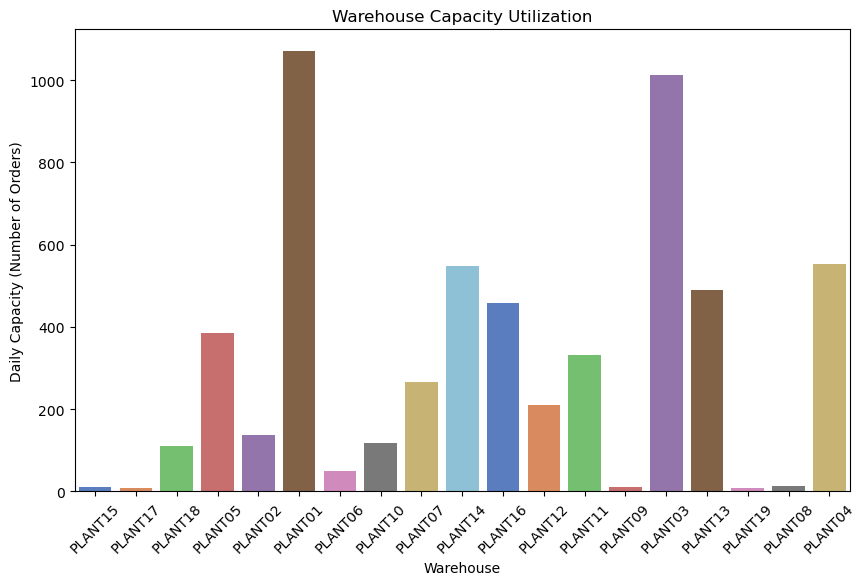

In [10]:
# Capacity Utilization of Warehouses
plt.figure(figsize=(10, 6))
sns.barplot(data=warehouse_capacities, x="Plant ID", y="Daily Capacity ", palette="muted")
plt.title("Warehouse Capacity Utilization")
plt.xlabel("Warehouse")
plt.ylabel("Daily Capacity (Number of Orders)")
plt.xticks(rotation=45)
plt.show()

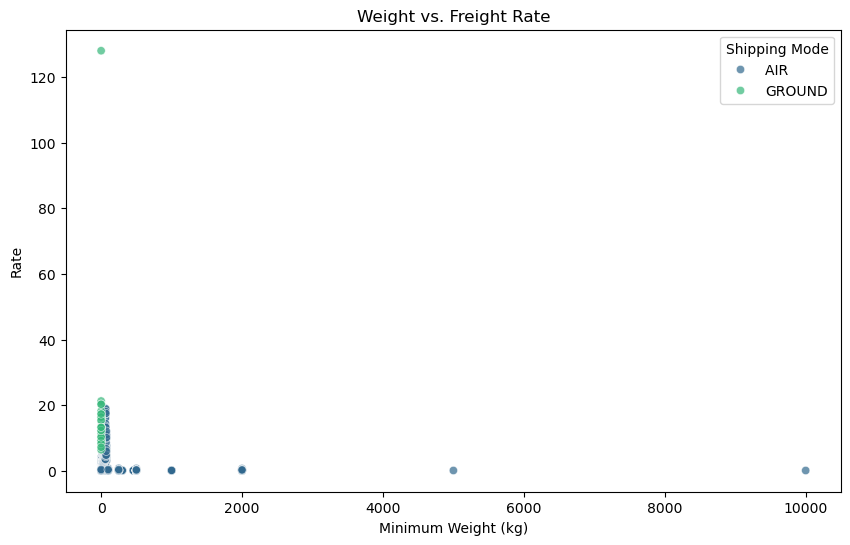

In [11]:
# Relationship Between Weight and Freight Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=freight_rates, x="minm_wgh_qty", y="rate", hue="mode_dsc", palette="viridis", alpha=0.7)
plt.title("Weight vs. Freight Rate")
plt.xlabel("Minimum Weight (kg)")
plt.ylabel("Rate")
plt.legend(title="Shipping Mode")
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\2177332906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=order_list, y="Customer", order=order_list["Customer"].value_counts().index[:10], palette="pastel")


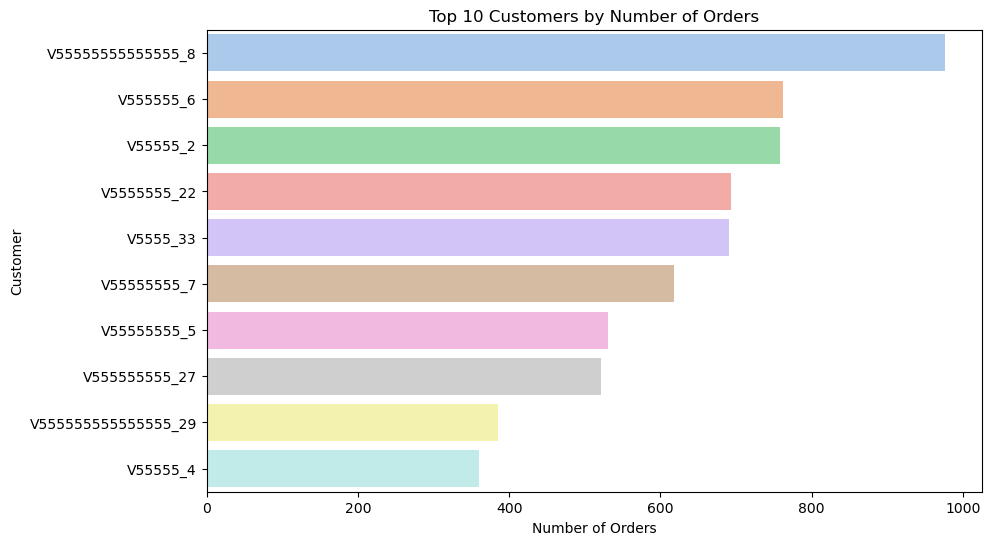

In [12]:
# Customer Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=order_list, y="Customer", order=order_list["Customer"].value_counts().index[:10], palette="pastel")
plt.title("Top 10 Customers by Number of Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Customer")
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\4294841972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=products_per_plant_count, x="Plant Code", y="Product Count", palette="coolwarm")


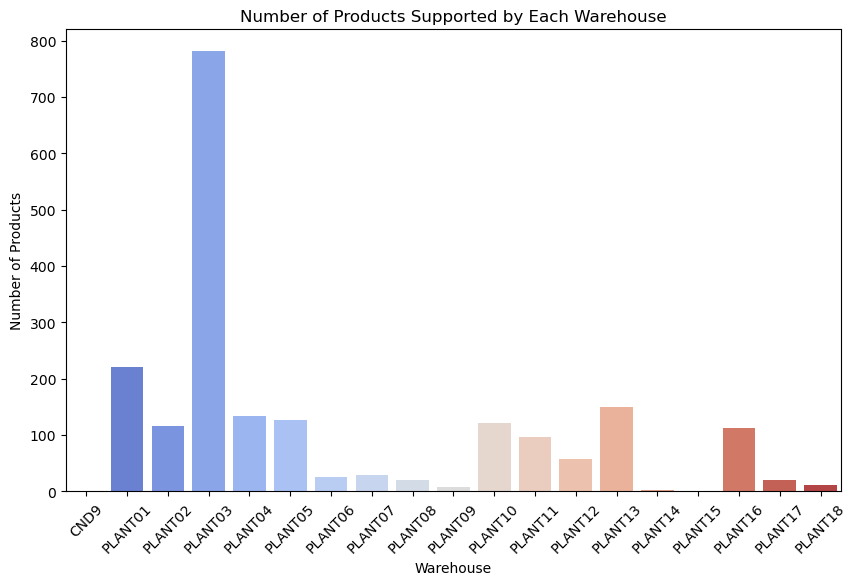

In [13]:
# Products Supported per Warehouse
products_per_plant_count = products_per_plant.groupby("Plant Code").size().reset_index(name="Product Count")
plt.figure(figsize=(10, 6))
sns.barplot(data=products_per_plant_count, x="Plant Code", y="Product Count", palette="coolwarm")
plt.title("Number of Products Supported by Each Warehouse")
plt.xlabel("Warehouse")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.show()

## 3. Freight & Shipping Optimization

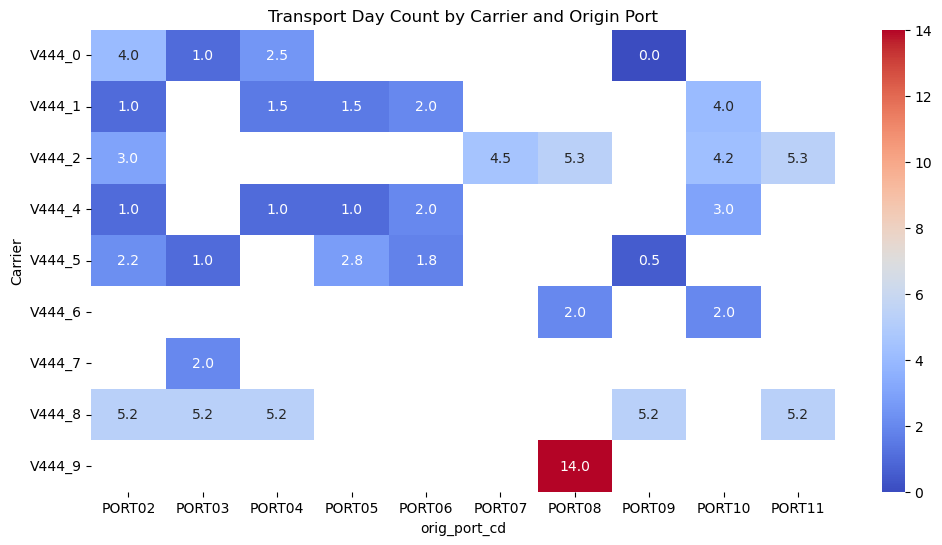

In [14]:
# Group by carrier and origin port, and calculate the mean of 'tpt_day_cnt'
shipping_trends = freight_rates.groupby(['Carrier', 'orig_port_cd'])['tpt_day_cnt'].mean()

# Plot the trends to visualize them
plt.figure(figsize=(12, 6))
sns.heatmap(shipping_trends.unstack(), annot=True, cmap="coolwarm", fmt='.1f')
plt.title("Transport Day Count by Carrier and Origin Port")
plt.show()

## Key Observation

Each row shows the average number of transport days for a particular carrier and origin port combination.

For example, Carrier V444_0 has:

- 4 days from PORT02: This indicates relatively longer transport times from this port for this carrier.
- 0 days from PORT09: This might indicate no shipments or extremely fast delivery (e.g., same-day processing).

Carrier V444_9 from PORT08 has the highest value of 14 days, suggesting this route might involve international shipping or significant logistical delays.

### Cost-Effective Carriers for Different Weight Ranges and Service Levels

To identify the most cost-effective carriers based on weight range and service level, you can group by those attributes and calculate the average rate.

In [15]:
# Categorize products into weight ranges
bins = [0, 5, 10, 20, 50, 100, 200, 500, float('inf')]
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200-500', '500+']
freight_rates['Weight Range'] = pd.cut(freight_rates['minm_wgh_qty'], bins=bins, labels=labels)

# Group by weight range and service level, and find the cheapest carrier
cost_effective_carriers = freight_rates.groupby(['Weight Range', 'svc_cd']).apply(
    lambda x: x.loc[x['rate'].idxmin()])

# Display the most cost-effective carriers
print(cost_effective_carriers[['Carrier', 'rate', 'Weight Range', 'svc_cd']])

                    Carrier      rate Weight Range svc_cd
Weight Range svc_cd                                      
0-5          DTD     V444_1  0.202000          0-5    DTD
             DTP     V444_4  0.476800          0-5    DTP
5-10         DTD     V444_1  0.677600         5-10    DTD
             DTP     V444_4  0.787200         5-10    DTP
10-20        DTD     V444_4  0.994800        10-20    DTD
             DTP     V444_4  1.090400        10-20    DTP
20-50        DTD     V444_1  0.140912        20-50    DTD
             DTP     V444_4  1.046800        20-50    DTP
50-100       DTD     V444_8  0.033200       50-100    DTD
             DTP     V444_0  0.042400       50-100    DTP
100-200      DTD        NaN       NaN          NaN    NaN
             DTP        NaN       NaN          NaN    NaN
200-500      DTD     V444_8  0.033200      200-500    DTD
             DTP     V444_0  0.042400      200-500    DTP
500+         DTD     V444_8  0.033200         500+    DTD
             D

C:\Users\milto\AppData\Local\Temp\ipykernel_7716\608560525.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cost_effective_carriers = freight_rates.groupby(['Weight Range', 'svc_cd']).apply(
C:\Users\milto\AppData\Local\Temp\ipykernel_7716\608560525.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cost_effective_carriers = freight_rates.groupby(['Weight Range', 'svc_cd']).apply(


### Most Cost-Effective Carriers by Weight Range:

0-5 kg:
- DTD: V444_1 → Rate: 0.2020 (Most cost-effective for Door-to-Door)
- DTP: V444_4 → Rate: 0.4768 (Only option for Door-to-Port)

5-10 kg:
- DTD: V444_1 → Rate: 0.6776 (Cheapest for Door-to-Door)
- DTP: V444_4 → Rate: 0.7872

10-20 kg:
- DTD: V444_4 → Rate: 0.9948 (Only available option)
- DTP: V444_4 → Rate: 1.0904

20-50 kg:
- DTD: V444_1 → Rate: 0.1409 (Most cost-effective for Door-to-Door)
- DTP: V444_4 → Rate: 1.0468

50-100 kg:
- DTD: V444_8 → Rate: 0.0332 (Lowest rate in this range)
- DTP: V444_0 → Rate: 0.0424

100-200 kg:
- No carriers listed. This could indicate no shipments in this range or missing data.

200-500 kg:
- DTD: V444_8 → Rate: 0.0332 (Most cost-effective)
- DTP: V444_0 → Rate: 0.0424

500+ kg:
- DTD: V444_8 → Rate: 0.0332 (Best rate for high-weight shipments)
- DTP: V444_0 → Rate: 0.0424

### Shipping Delays by Port and Carrier

To analyze how often certain ports experience shipping delays and whether there are consistent issues with specific carriers or routes, you can check if there's a threshold for delays (e.g., if ship_late_day_cnt > 0 indicates a delay).

orig_port_cd  Carrier
PORT02        V444_0       5
              V444_1      20
              V444_2       5
              V444_4     151
              V444_5      25
              V444_8      15
PORT03        V444_0      12
              V444_5      12
              V444_7       1
              V444_8      15
PORT04        V444_0      20
              V444_1      40
              V444_4     151
              V444_8      15
PORT05        V444_1      48
              V444_4     151
              V444_5      20
PORT06        V444_1     152
              V444_4     302
              V444_5      25
PORT07        V444_2      20
PORT08        V444_2      15
              V444_6      19
              V444_9       5
PORT09        V444_5       1
              V444_8      15
PORT10        V444_1      32
              V444_2      20
              V444_4     151
              V444_6      19
PORT11        V444_2      15
              V444_8      15
Name: tpt_day_cnt, dtype: int64


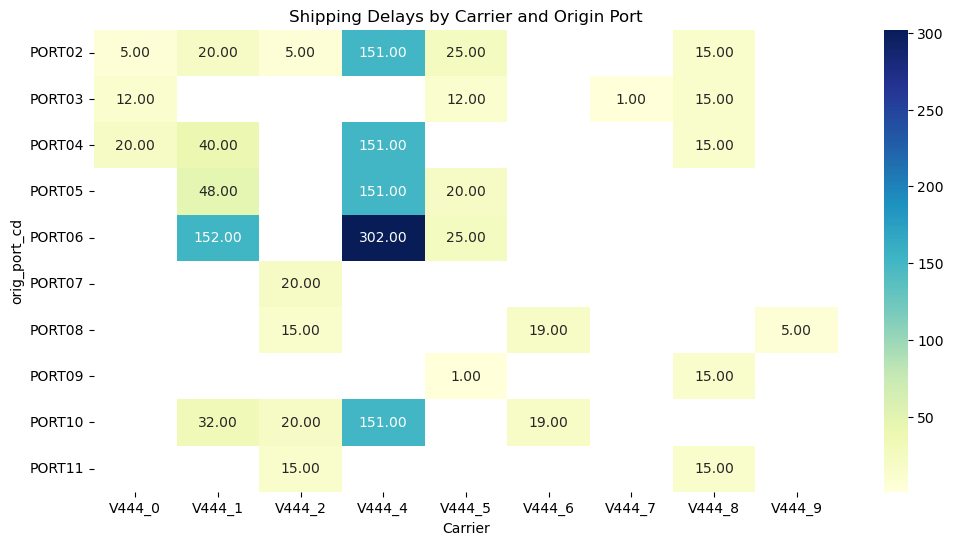

In [16]:
# Count the number of delays for each port and carrier
delay_counts = freight_rates[freight_rates['tpt_day_cnt'] > 0].groupby(['orig_port_cd', 'Carrier'])['tpt_day_cnt'].count()

# Display delay counts
print(delay_counts)

# Plot delays for better visualization
plt.figure(figsize=(12, 6))
sns.heatmap(delay_counts.unstack(), annot=True, cmap="YlGnBu", fmt='.2f')  # Use .2f for floating point values
plt.title("Shipping Delays by Carrier and Origin Port")
plt.show()

### Key Patterns and Insights:

- V444_4 consistently shows the highest number of delays across multiple ports, particularly in PORT02, PORT04, PORT05, PORT06, and PORT10. This indicates systemic issues with this carrier's operations.
- V444_1 shows moderate delays but spikes significantly in PORT06.
- V444_8 appears consistently across multiple ports with a 15 delay count, suggesting a common underlying issue across its routes.
- PORT06 is the most problematic port, particularly with V444_4 and V444_1, indicating severe operational challenges.

## 4. Port & Logistics Optimization

Which origin and destination ports have the highest volume of shipments, and are there any delays associated with these ports?

  Origin Port Destination Port  Shipment Volume  Average Delay
0      PORT04           PORT09             9041       0.040703
2      PORT09           PORT09              173       0.000000
1      PORT05           PORT09                1       0.000000


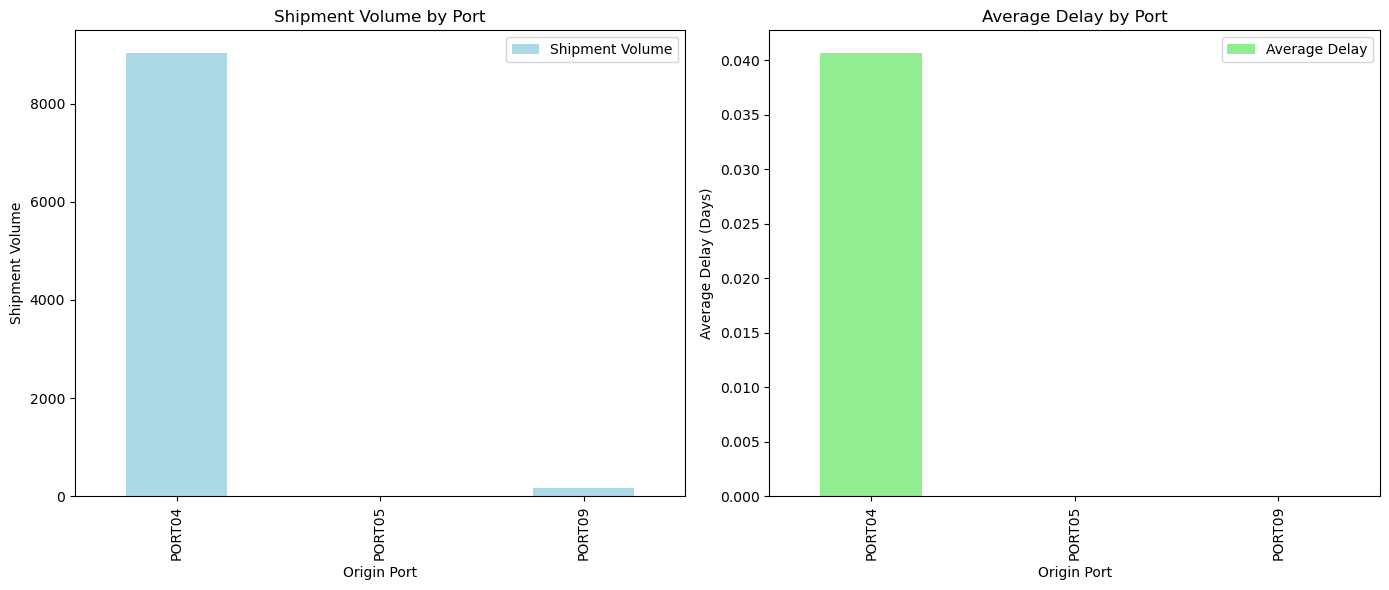

In [18]:
# Group by 'Origin Port' and 'Destination Port' to get the shipment volume
shipment_volume = order_list.groupby(['Origin Port', 'Destination Port']).size().reset_index(name='Shipment Volume')

# Merge with shipping delays to check if there are delays associated with these ports
delayed_shipments = order_list.groupby(['Origin Port', 'Destination Port'])['Ship Late Day count'].mean().reset_index(name='Average Delay')

# Merge both shipment volume and delay information
port_shipment_info = pd.merge(shipment_volume, delayed_shipments, on=['Origin Port', 'Destination Port'])

# Sort by shipment volume to see the highest volume ports
port_shipment_info = port_shipment_info.sort_values(by='Shipment Volume', ascending=False)

# Display the top 10 origin-destination port pairs with highest shipment volume and delays
print(port_shipment_info.head(10))

# Visualize shipment volume and delays
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Shipment Volume plot
shipment_volume.plot(kind='bar', x='Origin Port', y='Shipment Volume', ax=ax[0], color='lightblue', title='Shipment Volume by Port')
ax[0].set_ylabel('Shipment Volume')

# Delay plot
delayed_shipments.plot(kind='bar', x='Origin Port', y='Average Delay', ax=ax[1], color='lightgreen', title='Average Delay by Port')
ax[1].set_ylabel('Average Delay (Days)')

plt.tight_layout()
plt.show()

### Key Insights:

High Shipment Volume with Minor Delays:
- PORT04 → PORT09 is the most crucial route due to its high volume.
- Despite the minor average delay, the high volume suggests the potential for a larger cumulative impact on delivery timelines.
- Investigate potential causes for the delays, such as congestion, processing times, or carrier issues.

Consistently On-Time Routes:
- PORT09 → PORT09 and PORT05 → PORT09 are consistently on time.
- These routes are efficient but have low shipment volumes.
- Consider whether they can support additional volume to balance the load from more congested routes.

## Conclusion

The findings reveal that strategic adjustments, such as optimizing shipping routes, selecting cost-effective carriers, and balancing warehouse capacities, can reduce transportation costs and improve overall supply chain efficiency. Additionally, analyzing shipment volumes and delays across different ports allows for better decision-making regarding route selection and inventory management.

These findings serve as a foundation for future optimization initiatives, such as predictive modeling for demand forecasting, real-time monitoring of logistics performance, and advanced routing algorithms.